# DOGS VS CATS REDUX CODE

I'm trying to cover all the concepts covered in Lesson 1 through 7 with regard to CNN. The code runs on sample data. 

## Initial Imports and Setup

In [1]:
# Try '% + Tab' and it gives you a list of commands that can be run in the notebook just as if it were in the terminal.
# Here we are checking the present working directory
%pwd

u'/home/nami/kaggle'

In [2]:
# This command helps us to make and see plots within the notebook [a python 2D plotting library] 
%matplotlib inline

#import modules that we will be using in the code
from utils import *
from vgg16 import Vgg16

# Enter the path to your data in the working directory
# path = "data/redux/" # Use this path if you are using the entire dataset
path = "data/redux/sample/" # Use this path if you are using sample dataset

Using Theano backend.


In [3]:
# Other imports. Add the imports as and when you are using any particular library
import os,sys
from shutil import copyfile
import gc

## Setting up Data Folders
### This piece of code needs to be run only the very first time you run the code as they are one-time setups*

In [4]:
# Create directories
%cd data/redux
%mkdir valid
%mkdir results
%mkdir pred
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p sample/pred
%mkdir -p test/unknown

/home/nami/kaggle/data/redux
mkdir: cannot create directory ‘valid’: File exists
mkdir: cannot create directory ‘results’: File exists


In [5]:
%cd train

/home/nami/kaggle/data/redux/train


In [6]:
# Move images to valid data folders from train data folder
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000): os.rename(shuf[i], '../valid/' + shuf[i])

In [7]:
# Copy a few images to sample/train from train data folder
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], '../sample/train/' + shuf[i])

In [8]:
%cd ../valid

/home/nami/kaggle/data/redux/valid


In [9]:
# Copy a few images to sample/valid from valid data folder
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], '../sample/valid/' + shuf[i])

In [ ]:
%cd ../test

In [ ]:
# Copy all (or a few) the images in test folder to sample/test folder
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(100): copyfile(shuf[i], '../sample/valid/' + shuf[i])

In [10]:
# Rearrange all the images to separate dogs and cats directories 
# in the train, valid, sample/train, sample/valid directories
%cd ../sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd ../valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd ../../valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd ../train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/nami/kaggle/data/redux/sample/train
/home/nami/kaggle/data/redux/sample/valid
/home/nami/kaggle/data/redux/valid
/home/nami/kaggle/data/redux/train


In [11]:
# Create a single 'unknown' class for test set as the code looks for sub-directories
%cd ../test
%mv *.jpg unknown/

%cd ../sample/test
%mv *.jpg unknown/

/home/nami/kaggle/data/redux/test


In [9]:
%cd ../../../..

/home/nami


## Using a Trained Model and Finetuning it (VGG16)

In [4]:
#import Vgg16 helper class
vgg = Vgg16()
adam_model = vgg.model

/home/nami/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [5]:
# Use this command (you need to 'import gc') to free the RAM once in a while
gc.collect()

26

In [6]:
# Set batch size
batch_size = 4

In [7]:
# Create batches of training and validation
gen=image.ImageDataGenerator()
batches = gen.flow_from_directory(path+'train', target_size=(224,224), 
                                  class_mode='categorical', shuffle=True, batch_size=batch_size)
val_batches = gen.flow_from_directory(path+'valid', target_size=(224,224), 
                                  class_mode='categorical', shuffle=True, batch_size=batch_size)

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [8]:
# Finetune the original model to suit our needs
adam_model.pop()
for layer in adam_model.layers: layer.trainable=False
adam_model.add(Dense(batches.nb_class, activation='softmax'))
adam_model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

## Train the Finetuned Model

In [9]:
# We will train the new model with the changes which we have just made to it. Trains only the modified layers
adam_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=3,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/3
200/200 [==============================] - 98s - loss: 0.9431 - acc: 0.6700 - val_loss: 0.4024 - val_acc: 0.8200

In [10]:
# We can further train it using different learning rates and number of epochs
adam_model.optimizer.lr = 0.001
adam_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=3,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/3
200/200 [==============================] - 92s - loss: 0.2246 - acc: 0.9200 - val_loss: 0.2993 - val_acc: 0.8600

In [11]:
# Find out how the model is structured
adam_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [12]:
adam_model.save_weights(path+'results/simple_vgg_Adam.h5')

## Optimizers

We can change the optimizers and check how well the model trains for each optimizer

In [ ]:
%xdel adam_model
gc.collect()

In [ ]:
sgd_model = vgg.model

In [ ]:
sgd_model.pop()
for layer in sgd_model.layers: layer.trainable=False
sgd_model.add(Dense(batches.nb_class, activation='softmax'))
sgd_model.compile(optimizer=SGD(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
sgd_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=3,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/3
200/200 [==============================] - 145s - loss: 0.1424 - acc: 0.9550 - val_loss: 0.2519 - val_acc: 0.9400

In [ ]:
sgd_model.save_weights(path+'results/simple_vgg_SGD.h5')

In [ ]:
%xdel sgd_model
gc.collect()

In [68]:
rms_model = vgg.model

NameError: name 'Adagrad' is not defined

In [ ]:
rms_model.pop()
for layer in rms_model.layers: layer.trainable=False
rms_model.add(Dense(batches.nb_class, activation='softmax'))
rms_model.compile(optimizer=SGD(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
rms_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=3,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [ ]:
rms_model.save_weights(path+'results/simple_vgg_RMSprop.h5')

## Removing all Dense Layers of VGG

There is no use retraining the convolutional layers of a pre-trained model considering that it is only extracting the features of the image that passes through it. Hence we can try to change the dense layers to make our model better for specific classification problems.

In [ ]:
%xdel rms_model
gc.collect()

In [ ]:
model = vgg.model

In [27]:
model.pop()
model.pop()
model.pop()
model.pop()
model.pop()
model.pop()
model.pop()

I've added batchnormalization to the last convolutional layer and after each dense layers. Dropout and L1, L2 regularization too can be added at this point. But it is not advisable for sample data set as regularization is directly related to the amount of data we have; more the data, more regularization needs to be added.

In [30]:
# Adding Batchnormalization, dropout, L2 regularization
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D())
model.add(Flatten())
#model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax', W_regularizer=l2(0.01)))

In [31]:
model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [33]:
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=3,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/3
200/200 [==============================] - 120s - loss: 1.0178 - acc: 0.5800 - val_loss: 1.2887 - val_acc: 0.6000

In [34]:
model.optimizer.lr = 0.001
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=3,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/3
200/200 [==============================] - 93s - loss: 0.2460 - acc: 0.9150 - val_loss: 1.1693 - val_acc: 0.5200

In [ ]:
model.save_weights(path+'results/vgg_dense_replace.h5')

## Visualizing Results

To visualize results i.e. to check how well the model is performing we use the validation dataset. The confusion matrix is used to see the performance of the model in a matrix form. This part is not necessary in the code, but helps us t understand what problems are being faced by the model in classification

In [35]:
# Free up the RAM a bit
gc.collect()

1589

In [36]:
val_preds = model.predict_generator(val_batches, val_samples = val_batches.nb_sample)

In [38]:
# These are the image names as we see in the folders
filenames = val_batches.filenames
# These are the labels for each image in the validation set (0 - cat, 1 - dog)
expected_labels = val_batches.classes

In [39]:
# The predictions we get are rounded of to 0 or 1
our_predictions = val_preds[:,0]
our_labels = np.round(1-our_predictions)

In [40]:
from keras.preprocessing import image

# Helper function to plot images by index in the validation set 
# Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)
    
# Number of images to view for each visualization task
n_view = 3

Found 28 correct labels


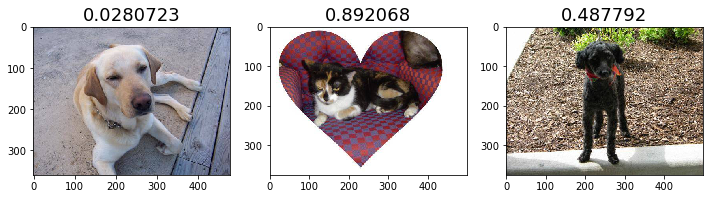

In [43]:
# 1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 22 incorrect labels


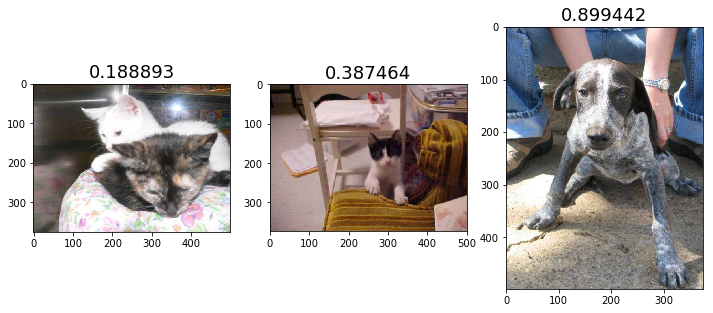

In [44]:
# 2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 13 confident correct cats labels


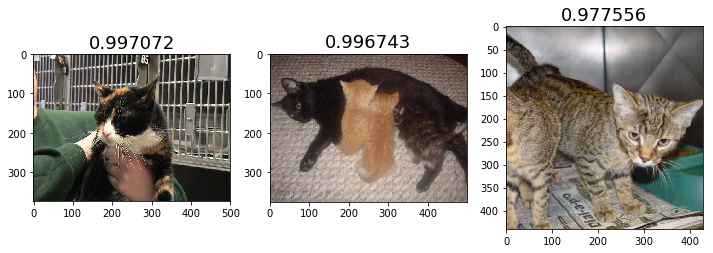

In [45]:
# 3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print "Found %d confident correct cats labels" % len(correct_cats)
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 15 confident correct dogs labels


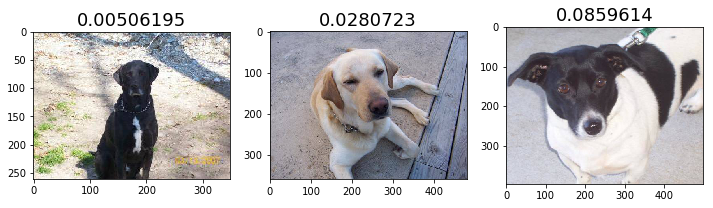

In [46]:
# 3b. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print "Found %d confident correct dogs labels" % len(correct_dogs)
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

Found 9 incorrect cats


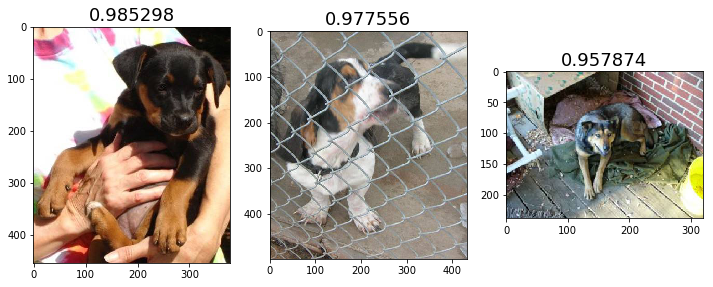

In [47]:
# 4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print "Found %d incorrect cats" % len(incorrect_cats)
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Found 13 incorrect dogs


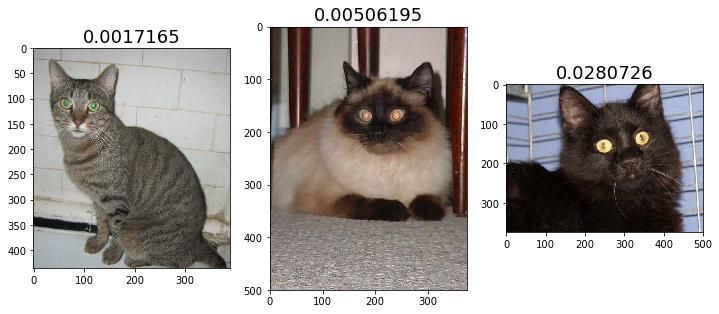

In [48]:
# 4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print "Found %d incorrect dogs" % len(incorrect_dogs)
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

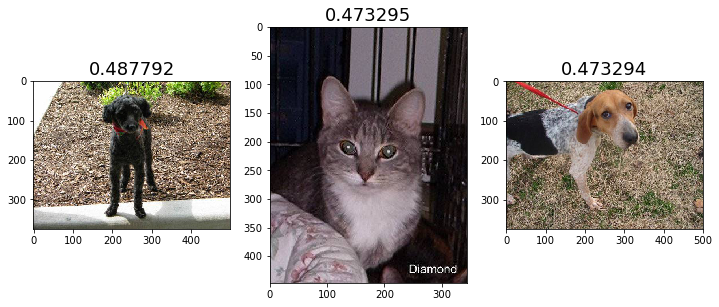

In [49]:
# 5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

In [50]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

[[13 13]
 [ 9 15]]


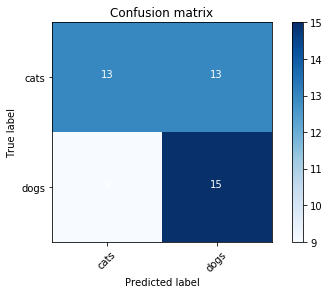

In [52]:
plot_confusion_matrix(cm, val_batches.class_indices)

## Data Augmentation

In [53]:
gc.collect()

49974

In [54]:
model.optimizer.lr = 0.001

In [66]:
# Generate a set of images from train data using variations like rotate, height shift, width shift, etc.
gen_t = image.ImageDataGenerator(rotation_range=15)

batches = gen_t.flow_from_directory(path+'train', target_size=(224,224), 
                                  class_mode='categorical', shuffle=True, batch_size=batch_size)

Found 200 images belonging to 2 classes.


In [67]:
# And train the model
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=3,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/3
200/200 [==============================] - 154s - loss: 0.6500 - acc: 0.7150 - val_loss: 1.2027 - val_acc: 0.4800

In [ ]:
gen_t = image.ImageDataGenerator(height_shift_range=0.05)

batches = gen_t.flow_from_directory(path+'train', target_size=(224,224), 
                                  class_mode='categorical', shuffle=True, batch_size=batch_size)

In [ ]:
# And train the model
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=3,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [ ]:
gen_t = image.ImageDataGenerator(shear_range=0.1)

batches = gen_t.flow_from_directory(path+'train', target_size=(224,224), 
                                  class_mode='categorical', shuffle=True, batch_size=batch_size)

In [ ]:
# And train the model
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=3,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [ ]:
gen_t = image.ImageDataGenerator(channel_shift_range=20)

batches = gen_t.flow_from_directory(path+'train', target_size=(224,224), 
                                  class_mode='categorical', shuffle=True, batch_size=batch_size)

In [ ]:
# And train the model
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=3,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [ ]:
gen_t = image.ImageDataGenerator(width_shift_range=0.1)

batches = gen_t.flow_from_directory(path+'train', target_size=(224,224), 
                                  class_mode='categorical', shuffle=True, batch_size=batch_size)

In [ ]:
# And train the model
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=3,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [ ]:
model.save_weights(path+'results/data_aug.h5')

In [ ]:
# Generate a set of images from train data by combining all the variations like rotate, height shift, width shift, etc.
gen_t = image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.05, shear_range=0.1, channel_shift_range=20, 
                                 rotation_range=15)

batches = gen_t.flow_from_directory(path+'train', target_size=(224,224), 
                                  class_mode='categorical', shuffle=True, batch_size=batch_size)

In [ ]:
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=3,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [ ]:
model.save_weights(path+'results/data_aug_all.h5')

## Pseudo Labeling

In [25]:
gc.collect()

0

In [ ]:
# Load the weights of the model that has given you the best accuracy
model.load_weights(path+'results/data_aug_all.h5')

In [16]:
# Run the code for the test images and classify them
test_batches = gen.flow_from_directory(path+'test', target_size=(224,224), 
                                  class_mode='categorical', shuffle=True, batch_size=batch_size)
test_feat = model.predict_generator(test_batches, val_samples = test_batches.nb_sample)

Found 100 images belonging to 1 classes.


In [42]:
test_filenames = test_batches.filenames

In [33]:
%cd data/redux/sample/train

/home/nami/kaggle/data/redux/sample/train


In [36]:
# Make directory called pred to classify the test images into
for d in glob('*'):
    os.mkdir('../sample/pred/'+d)

OSError: [Errno 2] No such file or directory: '../sample/pred/dogs'

In [37]:
%cd ../../../..

/home/nami/kaggle


In [21]:
# Store the result into an excel sheet
result_name = path+'results/result.xlsx'

In [38]:
def do_clip(arr, mx): return np.clip(arr, (1-mx)/9, mx)

In [39]:
subm = do_clip(test_feat,0.97)

In [40]:
classes = sorted(batches.class_indices, key=batches.class_indices.get)

In [43]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'img', [a[4:] for a in test_filenames])

In [44]:
submission.to_excel(result_name, index=False)

In [45]:
gc.collect()

0

In [46]:
from openpyxl import *

In [47]:
wb = load_workbook(path+'results/result.xlsx')
sheet = wb.get_sheet_by_name('Sheet1')

In [48]:
for i in range(2, test_batches.nb_sample):
    val1 = sheet.cell(row=i, column=2).value
    col = 2
    for j in range(3, batches.n):
        if sheet.cell(row=i, column=j).value > val: 
            val = sheet.cell(row=i,column=j).value
            col = j
    img = sheet.cell(row=i,column=1).value
    f = sheet.cell(row=1, column = col-2).value
    %cd data/state/sample/test/unknown
    g = glob('*.jpg')
    for i in range (test_batches.nb_sample):
        if g[i]==str(img):
            copyfile(g[i], '../../pred/' + str(f) + '/' + g[i])
    %cd ../../../../..

/home/nami/kaggle/data/state/sample/test/unknown
/home/nami/kaggle
/home/nami/kaggle/data/state/sample/test/unknown
/home/nami/kaggle
/home/nami/kaggle/data/state/sample/test/unknown
/home/nami/kaggle
/home/nami/kaggle/data/state/sample/test/unknown
/home/nami/kaggle
/home/nami/kaggle/data/state/sample/test/unknown
/home/nami/kaggle
/home/nami/kaggle/data/state/sample/test/unknown
/home/nami/kaggle
/home/nami/kaggle/data/state/sample/test/unknown
/home/nami/kaggle
/home/nami/kaggle/data/state/sample/test/unknown
/home/nami/kaggle
/home/nami/kaggle/data/state/sample/test/unknown
/home/nami/kaggle
/home/nami/kaggle/data/state/sample/test/unknown
/home/nami/kaggle
/home/nami/kaggle/data/state/sample/test/unknown
/home/nami/kaggle
/home/nami/kaggle/data/state/sample/test/unknown
/home/nami/kaggle
/home/nami/kaggle/data/state/sample/test/unknown
/home/nami/kaggle
/home/nami/kaggle/data/state/sample/test/unknown
/home/nami/kaggle
/home/nami/kaggle/data/state/sample/test/unknown
/home/nami/ka

In [49]:
# In the next few lines of code, the train data is merged into the pred folders to make it into a training folder that
# has the original training data and the pseudo labeled test data
%cd data/redux/sample/train/cats

/home/nami/kaggle/data/redux/sample/train/cats


In [51]:
g = glob('*.jpg')
for i in range(len(g)): copyfile(g[i], '../sample/pred/cats/' + g[i])

TypeError: cannot concatenate 'str' and 'list' objects

In [ ]:
%cd ../dogs

In [ ]:
g = glob('*.jpg')
for i in range(len(g)): copyfile(g[i], '../sample/pred/cats/' + g[i])

In [ ]:
% cd ../../../../..

In [ ]:
gc.collect()

In [ ]:
# Generate the new set of training batches
pred_batches = gen.flow_from_directory(path+'pred', target_size=(224,224), 
                                  class_mode='categorical', shuffle=True, batch_size=batch_size)

In [ ]:
# Train the model with the new set of data
model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=5,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [ ]:
model.save_weights(path+'results/pseudo_label.h5')

## Test the Model

In [ ]:
gc.collect()

In [ ]:
# We test the model using the test data made available
test_batches = gen.flow_from_directory(path+'test', target_size=(224,224), 
                                  class_mode='categorical', shuffle=True, batch_size=batch_size)
preds = model.predict_generator(test_batches, val_samples = test_batches.nb_sample)